# Driver of LIM using PyTorch

## Import Modules

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
# import pandas as pd
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod_pt import LIM, cov_lag

from read_AM_index_mod import Reanalysis, CMIP6

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")
# model_list.remove("CESM2-WACCM")
# model_list.remove("HadGEM3-GC31-LL")
# model_list.remove("HadGEM3-GC31-MM")
# model_list.remove("KACE")
# model_list.remove("UKESM1")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]

## Load JRA55 and CMIP6 data

In [2]:
D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55', \
        annual_cycle_fft=4, running_mean=0, save_index=True)

D0.y, _ = D0.slice_data(month_start=11, len_slice=150, month_start2=8)
D0.y = torch.from_numpy(D0.y.astype('float32'))
print(D0.name)

t = torch.linspace(0, D0.y.shape[1]-1, D0.y.shape[1], dtype=D0.y.dtype)
p = D0.level
print(f't.shape = {t.shape}, y.shape = {D0.y.shape}')

D_list = []
for model in model_list:
    D = CMIP6(name_dir=model, year_start=1958, year_end=2014, plev=plev, name=model, source_dir='cmip6', \
            annual_cycle_fft=4, running_mean=0, save_index=True)
    D.y, _ = D.slice_data(month_start=11, len_slice=150, month_start2=8)
    D.y = torch.from_numpy(D.y.astype('float32'))
    print(D.name)
    D_list.append(D)

print(f"total number of models: {len(D_list)}")

Reading from saved data ......
JRA55
t.shape = torch.Size([150]), y.shape = torch.Size([56, 150, 8])
Reading from saved data ......
ACCESS-CM2
Reading from saved data ......
BCC-ESM1
Reading from saved data ......
CanESM5
Reading from saved data ......
CESM2
Reading from saved data ......
CESM2-WACCM
Reading from saved data ......
CNRM-CM6
Reading from saved data ......
CNRM-CM6-HR
Reading from saved data ......
CNRM-ESM2
Reading from saved data ......
EC-Earth3
Reading from saved data ......
FGOALS-f3-L
Reading from saved data ......
FGOALS-g3
Reading from saved data ......
GFDL-ESM4
Reading from saved data ......
HadGEM3-GC31-LL
Reading from saved data ......
HadGEM3-GC31-MM
Reading from saved data ......
INM-CM4
Reading from saved data ......
INM-CM5
Reading from saved data ......
IPSL-CM6A-LR
Reading from saved data ......
KACE
Reading from saved data ......
MIROC6
Reading from saved data ......
MIROC-ES2L
Reading from saved data ......
MPI-ESM-1-2-HAM
Reading from saved data .....

## Hyperparameters

In [3]:
# hyperparameters
hyp_param = dict(lim = dict(method = 'DMD',
                            lag_time = 5,
                            eval_time = 20,
                            forecast_time = 40,
                            LIM = dict( r_optimal = None,
                                        ),
                            DMD = dict( r_alpha = 1,
                                        r_optimal = 5,
                                        r_forecast = 5,
                                       )
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'eval_time': 20, 'forecast_time': 40, 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 1, 'r_optimal': 5, 'r_forecast': 5}}}


## Model

In [4]:
def compute_tau(y, p, p_level, lag_time, verbose=False):
    lags = np.linspace(0, lag_time, lag_time+1, dtype=int)
    k = np.isin(p, p_level)
    Ct = np.array([cov_lag(y[:, :, k], lag) for lag in lags])

    from scipy.optimize import curve_fit
    func = lambda x, b: np.exp(-b * x)
    popt, pcov = curve_fit(func, lags, Ct/Ct[0])

    if verbose:
        plt.plot(lags, Ct/Ct[0])
        plt.plot(lags, func(lags, *popt))

    return 1.0/popt[0]

def run_model(D0, t, forecast_time, verbose=False):
    print(f'==================== {D0.name} ====================')
    D0.tau10 = compute_tau(D0.y, D0.level, p_level=10, lag_time=forecast_time)

    D0.model = LIM(D0.y, hyp_param, verbose=True)

    # forecasting
    D0.yf = D0.model.forecast(D0.y[:, :-forecast_time, :], t[:forecast_time+1])
    if verbose:
        print(f'y.shape={D0.y.shape}, yf.shape={D0.yf.shape}')

    # finding and plotting optimals
    D0.U, D0.s, D0.V = D0.model.optimals(t[:forecast_time+1], method='svd')


forecast_time = hyp_param['lim']['forecast_time']
run_model(D0, t, forecast_time, verbose=True)

for D in D_list:
    run_model(D, t, forecast_time)

==================== JRA55 ====================
r_opt=5: % of var=99.97969055175781, B_norm=0.3434509336948395, X_err=185.57078552246094, s=1.095610499382019
POP e-folding timescales =
 tensor([23.3919, 23.3919, 10.4264,  7.3009,  4.4967])
y.shape=torch.Size([56, 150, 8]), yf.shape=torch.Size([56, 41, 110, 8])
==================== ACCESS-CM2 ====================
r_opt=5: % of var=99.96177673339844, B_norm=0.619035005569458, X_err=178.11061096191406, s=1.142332911491394
POP e-folding timescales =
 tensor([23.9377, 14.6291,  9.4231,  3.4218,  3.4218])
==================== BCC-ESM1 ====================
r_opt=5: % of var=99.98381805419922, B_norm=0.3302847743034363, X_err=178.24610900878906, s=0.9382694363594055
POP e-folding timescales =
 tensor([20.6804, 20.6804, 11.7692,  6.5547,  6.5547])
==================== CanESM5 ====================
r_opt=5: % of var=99.9812240600586, B_norm=0.3864058554172516, X_err=174.89476013183594, s=1.1366183757781982
POP e-folding timescales =
 tensor([32.9

## Plot lagged regression

In [5]:
#=============================================================
# calculate covariance
#=============================================================
def cal_Ct_p(D0, p_level):
    k = np.isin(D0.level, p_level)
    Ct_p = np.array([cov_lag(D0.y[:, :, :], lag, D0.y[:, :, k]).numpy() for lag in lags])
    Ctf_p = np.array([cov_lag(D0.yf[:, lag, :, :], 0, D0.y[:, :-lag_time, k]).numpy() for lag in lags])
    return Ct_p, Ctf_p

lag_time = hyp_param['lim']['forecast_time']
lags = np.linspace(0, lag_time, lag_time+1, dtype=int)
Ct_p0, Ctf_p0 = cal_Ct_p(D0, p_level=10)

Ct_p = np.empty((len(D_list), *Ct_p0.shape))
Ctf_p = np.empty((len(D_list), *Ctf_p0.shape))
for i, D in enumerate(D_list):
    Ct_p[i, :, :], Ctf_p[i, :, :] = cal_Ct_p(D, p_level=10)


Text(0.5, 1.0, 'Multi-Model LIM (27)')

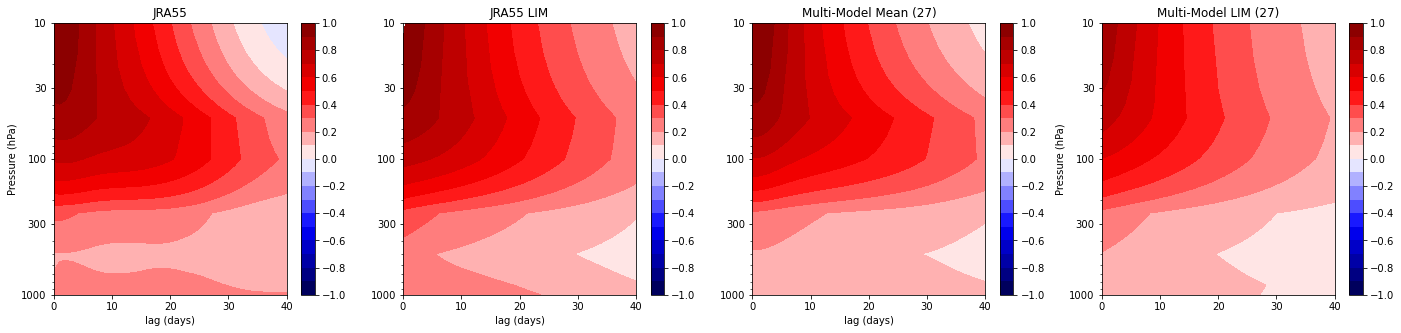

In [6]:
cmax = 1
cm = 'seismic' # 'bwr' 

fig = plt.figure(figsize=(24, 5))
fig.add_subplot(1, 4, 1)
plt.contourf(lags, D0.level, Ct_p0.T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title("JRA55")

fig.add_subplot(1, 4, 2)
plt.contourf(lags, D0.level, Ctf_p0.T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
# plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title("JRA55 LIM")

fig.add_subplot(1, 4, 3)
plt.contourf(lags, D.level, Ct_p.mean(axis=0).T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
# plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f"Multi-Model Mean ({len(D_list)})")

fig.add_subplot(1, 4, 4)
plt.contourf(lags, D.level, Ctf_p.mean(axis=0).T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
# plt.xlabel('lag (days)')
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f"Multi-Model LIM ({len(D_list)})")


# if True:
#         plt.savefig('Figs2/AM_reg_all.png', transparent=True)

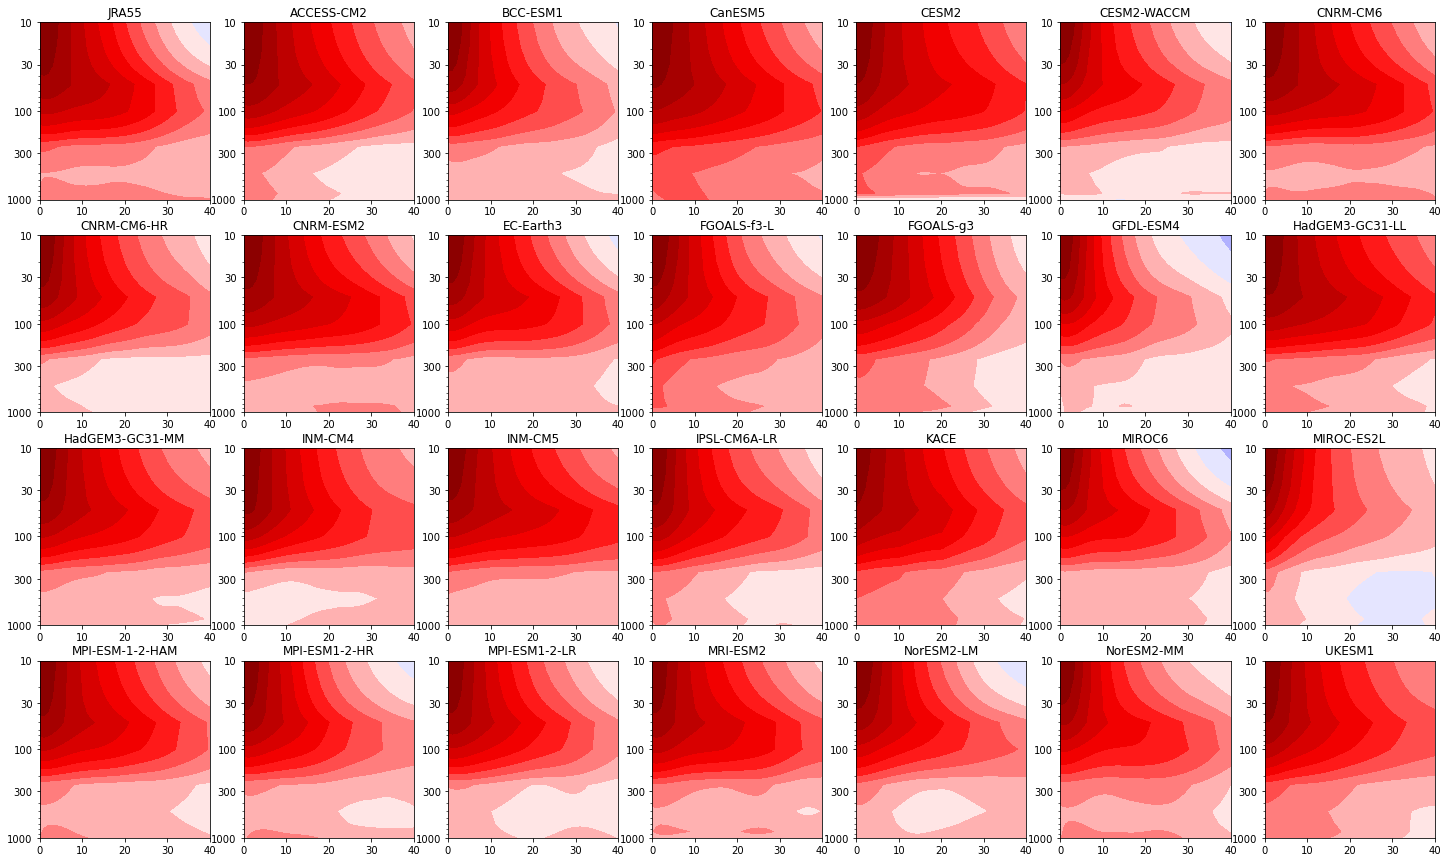

In [42]:
def plot_lag_reg(D0, Ct_p0):
    plt.contourf(lags, D0.level, Ct_p0.T, np.linspace(-cmax, cmax, 21), cmap=cm)
    # cbar = plt.colorbar()
    # cbar.set_ticks(np.linspace(-cmax, cmax, 11))
    plt.gca().invert_yaxis()
    # plt.xlabel('lag (days)')
    # plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(f"{D0.name}")

lag_time = hyp_param['lim']['forecast_time']
lags = np.linspace(0, lag_time, lag_time+1, dtype=int)

cmax = 1
cm = 'seismic' # 'bwr'
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(4, 7, 1)
plot_lag_reg(D0, Ct_p0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_lag_reg(D, Ct_p[i])


if True:
        plt.savefig('Figs2/AM_reg_all2.png', transparent=True)

## Plot weak vortex events

In [7]:
#=============================================================
# find weak or strong vortex events
#=============================================================
def find_event(y, p, yf=None, threshold=-3, separation=30, lag_time=60):
    """
    Input data: y(years, days, x), where years and days are time, and x is space
    p(x): pressure levels
    """
    
    # composite based on the annular mode index at p_level = 10 hPa
    p_level = 10
    k = np.isin(p, p_level)
    y10 = np.squeeze(y[:, :, k])

    if threshold > 0:
        idx_threshold = np.argwhere(y10 > threshold)
    else:
        idx_threshold = np.argwhere(y10 < threshold)

    idx_event = idx_threshold[0, :][None, :]
    for idx in idx_threshold[1:, :]:
        # print(idx_event, idx)
        if (idx[0] > idx_event[-1,0]) or (idx[1] - idx_event[-1,1] > separation):
            idx_event = np.vstack((idx_event, idx))

    if yf is None:
        y_event = np.zeros((0, lag_time+1, y.shape[2]))
        for idx in idx_event:
            yy, dd = idx[:]
            if dd+lag_time+1 <= y.shape[1]:
                y_event = np.vstack((y_event, y[yy, dd:dd+lag_time+1, :][None,:]))

        print(f'# of events: {len(y_event)}')
        return y_event.mean(axis=0)
    else:
        yf_event = np.zeros((0, lag_time+1, yf.shape[3]))
        for idx in idx_event:
            yy, dd = idx[:]
            if dd+lag_time+1 <= y.shape[1]:
                yf_event = np.vstack((yf_event, yf[yy, :lag_time+1, dd, :][None,:]))

        # print(f'# of events: {len(yf_event)}')
        return yf_event.mean(axis=0)


lag_time = hyp_param['lim']['forecast_time']
lags = np.linspace(0, lag_time, lag_time+1, dtype=int)
y0_neg_event = find_event(D0.y.numpy(), D0.level, threshold=-2, lag_time=lag_time)
yf0_neg_event = find_event(D0.y.numpy(), D0.level, yf=D0.yf.numpy(), threshold=-2, lag_time=lag_time)

y_neg_event = np.empty((len(D_list), *y0_neg_event.shape))
yf_neg_event = np.empty((len(D_list), *yf0_neg_event.shape))
for i, D in enumerate(D_list):
    y_neg_event[i, :, :] = find_event(D.y.numpy(), D.level, threshold=-2, lag_time=lag_time)
    yf_neg_event[i, :, :] = find_event(D.y.numpy(), D.level, yf=D.yf.numpy(), threshold=-2, lag_time=lag_time)
    


# of events: 26
# of events: 23
# of events: 23
# of events: 22
# of events: 25
# of events: 23
# of events: 23
# of events: 20
# of events: 23
# of events: 34
# of events: 24
# of events: 20
# of events: 27
# of events: 23
# of events: 19
# of events: 19
# of events: 20
# of events: 28
# of events: 19
# of events: 26
# of events: 19
# of events: 21
# of events: 26
# of events: 23
# of events: 25
# of events: 29
# of events: 24
# of events: 22


Text(0.5, 1.0, 'Multi-Model LIM (27)')

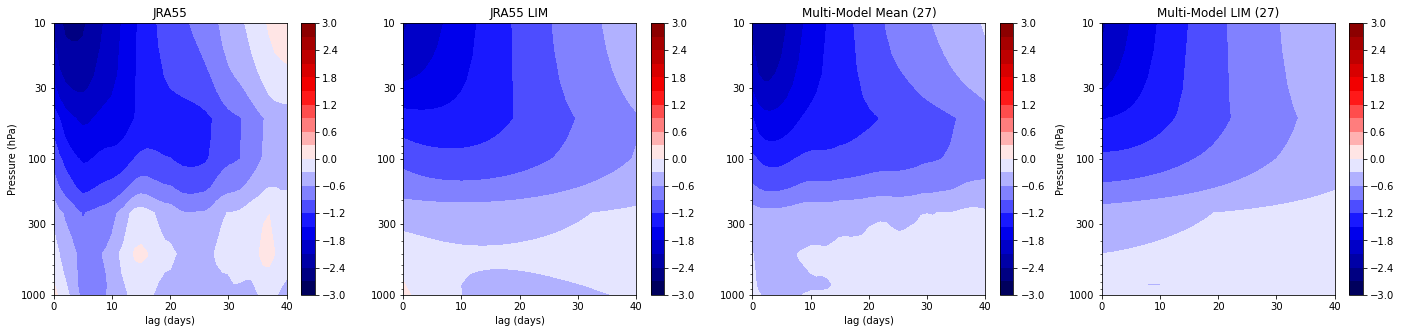

In [8]:
cmax = 3
cm = 'seismic' # 'bwr' 

fig = plt.figure(figsize=(24, 5))
ax = fig.add_subplot(1,4,1)
plt.contourf(lags, D0.level, y0_neg_event.T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f'JRA55')

ax = fig.add_subplot(1,4,2)
plt.contourf(lags, D0.level, yf0_neg_event.T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
# plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f'JRA55 LIM')

ax = fig.add_subplot(1,4,3)
plt.contourf(lags, D.level, y_neg_event.mean(axis=0).T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
plt.xlabel('lag (days)')
# plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f'Multi-Model Mean ({len(D_list)})')

ax = fig.add_subplot(1,4,4)
plt.contourf(lags, D.level, yf_neg_event.mean(axis=0).T, np.linspace(-cmax, cmax, 21), cmap=cm)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
plt.gca().invert_yaxis()
# plt.xlabel('lag (days)')
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(f'Multi-Model LIM ({len(D_list)})')


# if True:
#         plt.savefig('Figs2/AM_event_all.png', transparent=True)

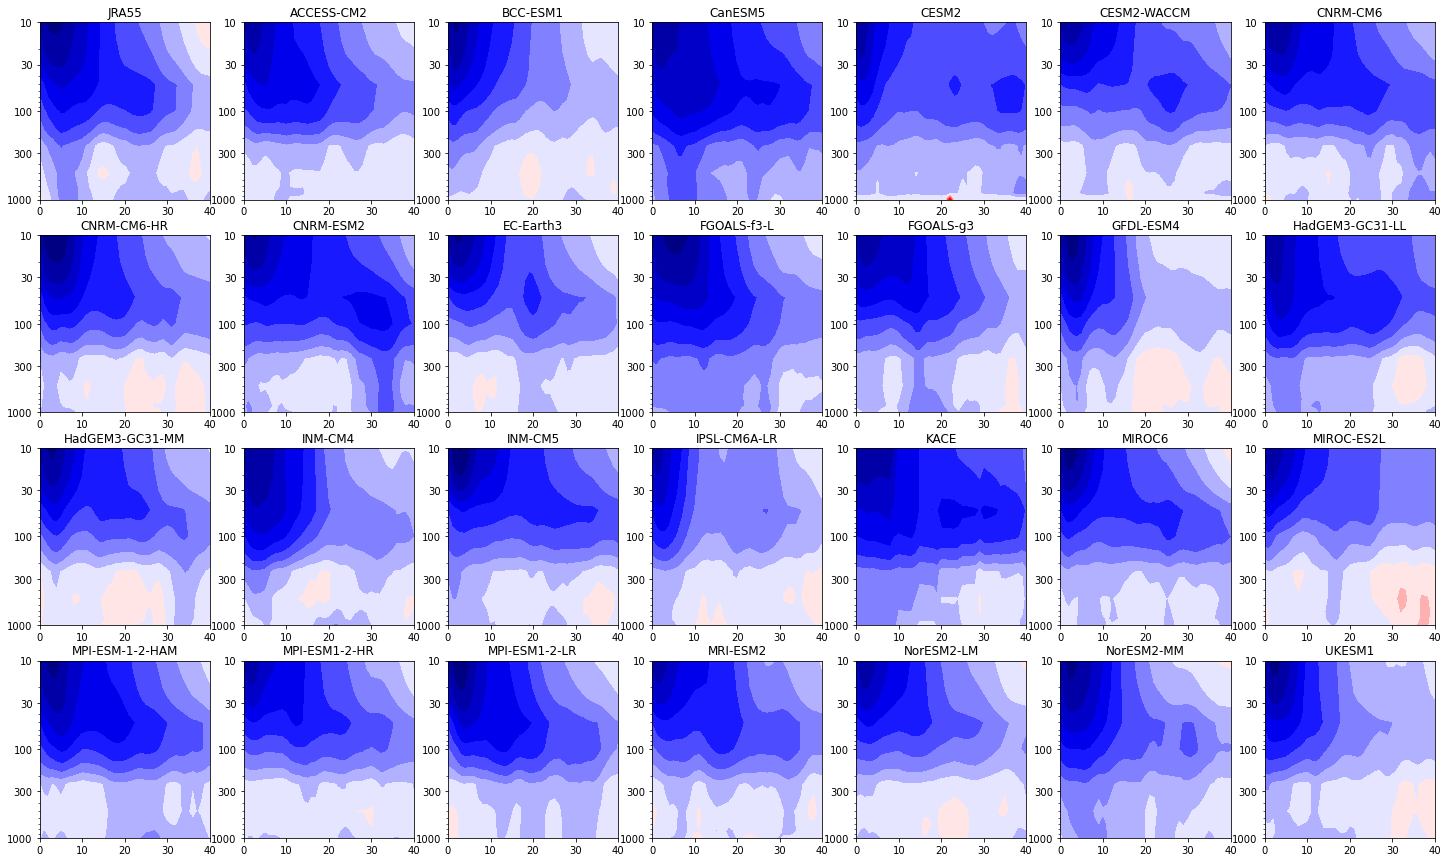

In [44]:
def plot_event(D0, y0_neg_event):
    plt.contourf(lags, D0.level, y0_neg_event.T, np.linspace(-cmax, cmax, 21), cmap=cm)
    # cbar = plt.colorbar()
    # cbar.set_ticks(np.linspace(-cmax, cmax, 11))
    plt.gca().invert_yaxis()
    # plt.xlabel('lag (days)')
    # plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(f'{D0.name}')


lag_time = hyp_param['lim']['forecast_time']
lags = np.linspace(0, lag_time, lag_time+1, dtype=int)

cmax = 3
cm = 'seismic' # 'bwr'
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(4, 7, 1)
plot_event(D0, y0_neg_event)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_event(D, y_neg_event[i])


if True:
        plt.savefig('Figs2/AM_event_all2.png', transparent=True)

(-0.7, 0.1)

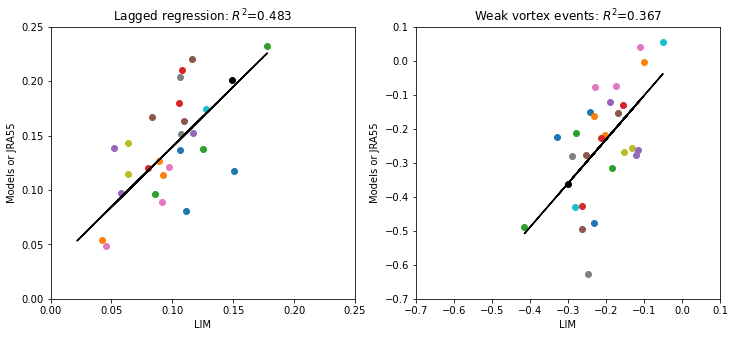

In [9]:
p_level = 850
lag_time = hyp_param['lim']['eval_time']

x = np.empty((len(D_list)))
y = np.empty_like(x)
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1,2,1)
for i, D in enumerate(D_list):
    k = np.isin(D.level, p_level)
    x[i] = Ctf_p[i, lag_time+1:, k].mean(axis=1)
    y[i] = Ct_p[i, lag_time+1:, k].mean(axis=1)
    plt.plot(x[i], y[i], 'o', label=D.name)

k = np.isin(D0.level, p_level)
x0 = Ctf_p0[lag_time+1:, k].mean(axis=0)
y0 = Ct_p0[lag_time+1:, k].mean(axis=0)
plt.plot(x0, y0, 'ok', label=D0.name)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.title(fr'Lagged regression: $R^2$={res.rvalue**2:.3f}')
plt.xlabel('LIM')
plt.ylabel('Models or JRA55')
# plt.xticks(np.arange(0, 0.251, 0.05))
# plt.yticks(np.arange(0, 0.251, 0.05))
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

fig.add_subplot(1,2,2)
for i, D in enumerate(D_list):
    k = np.isin(D.level, p_level)
    x[i] = yf_neg_event[i, lag_time+1:, k].mean(axis=1)
    y[i] = y_neg_event[i, lag_time+1:, k].mean(axis=1)
    plt.plot(x[i], y[i], 'o', label=D.name)

k = np.isin(D0.level, p_level)
x0 = yf0_neg_event[lag_time+1:, k].mean(axis=0)
y0 = y0_neg_event[lag_time+1:, k].mean(axis=0)
plt.plot(x0, y0, 'ok', label=D0.name)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.title(fr'Weak vortex events: $R^2$={res.rvalue**2:.3f}')
plt.xlabel('LIM')
plt.ylabel('Models or JRA55')
# plt.xticks(np.arange(0, 0.251, 0.05))
# plt.yticks(np.arange(0, 0.251, 0.05))
plt.xlim(-0.7, 0.1)
plt.ylim(-0.7, 0.1)


# if True:
#         plt.savefig('Figs2/lim_regress_events.png', transparent=True)

## Plot the linear operator

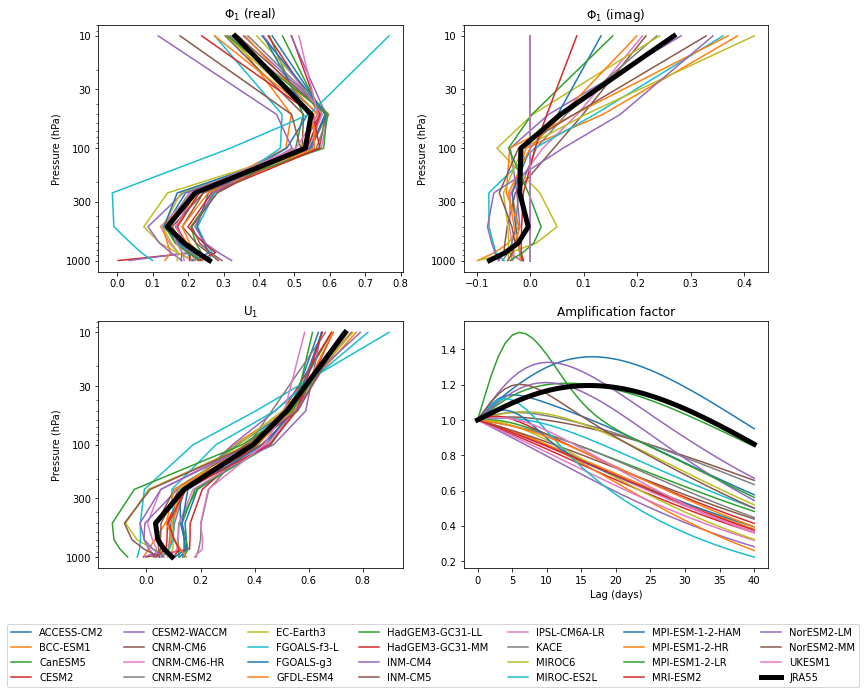

In [11]:
mm = 0
p_level = 10.
lag_time = hyp_param['lim']['eval_time']
forecast_time = hyp_param['lim']['forecast_time']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2,2,1)
for D in D_list:
    sn = np.sign(D.model.vr[np.isin(D.level, p_level), mm].real)
    plt.plot(D.model.vr[:, mm].real * sn, D.level, label=D.name)

sn = np.sign(D0.model.vr[np.isin(D0.level, p_level), mm].real)
plt.plot(D0.model.vr[:, mm].real * sn, D0.level,  color='k', linewidth=5, label=D0.name)
# plt.plot(p*0, p, '--k')

### OUTLIER
# DD = D_list[model_list.index('MIROC-ES2L')]
# sn = np.sign(DD.model.vr[np.isin(DD.level, p_level), mm].real)
# plt.plot(DD.model.vr[:, mm].real * sn, DD.level,  color='r', linewidth=5, label=DD.name)

plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r"$\Phi_1$ (real)")

ax = fig.add_subplot(2,2,2)
for D in D_list:
    sn = np.sign(D.model.vr[np.isin(D.level, p_level), mm].real)
    plt.plot(D.model.vr[:, mm].imag * sn, D.level, label=D.name)

sn = np.sign(D0.model.vr[np.isin(D0.level, p_level), mm].real)
plt.plot(D0.model.vr[:, mm].imag * sn, D0.level,  color='k', linewidth=5, label=D0.name)
# plt.plot(p*0, p, '--k')

plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r"$\Phi_1$ (imag)")

ax = fig.add_subplot(2,2,3)
for D in D_list:
    sn = np.sign(D.U[lag_time, np.isin(D.level, p_level)])
    plt.plot(D.U[lag_time, :]*sn, D.level, label=D.name)

sn = np.sign(D0.U[lag_time, np.isin(D0.level, p_level)])
plt.plot(D0.U[lag_time, :]*sn, D0.level,  color='k', linewidth=5, label=D0.name)
# plt.plot(p*0, p, '--k')

plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r"U$_1$")

ax = fig.add_subplot(2,2,4)
for D in D_list:
    plt.plot(t[:forecast_time+1], D.s, label=D.name)
plt.plot(t[:forecast_time+1], D0.s, color='k', linewidth=5, label=D0.name)

plt.xlabel('Lag (days)')
plt.title(r"Amplification factor")

legend = ax.legend(bbox_to_anchor=(-0.1,-0.5), loc='lower center', ncol=7)

# if True:
#         plt.savefig('Figs2/lim_operator.png', transparent=True)

## Plot timescales

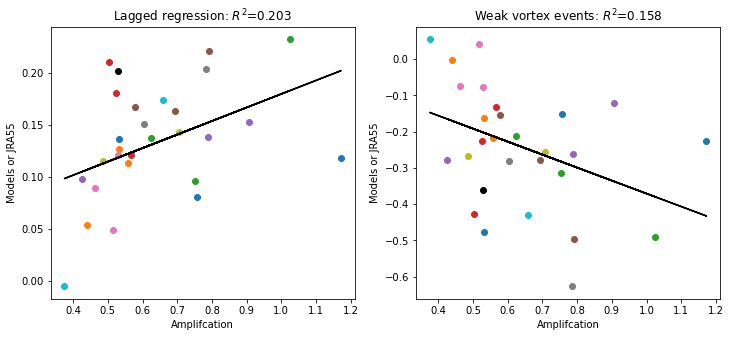

In [25]:
p_level = 850
lag_time = hyp_param['lim']['eval_time']
option =  'svd' # 'Z10'  # 'eig'

x = np.empty((len(D_list)))
y = np.empty_like(x)
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1,2,1)
for i, D in enumerate(D_list):
    k = np.isin(D.level, p_level)
    if option == 'eig':
        x[i] = -1/D.model.b[0].real # D.s[lag_time] # D.tau10 # Ctf_p[i, lag_time+1:, k].mean(axis=1)
    elif option == 'Z10':
        x[i] = D.tau10
    elif option == 'svd':
        x[i] = D.s[lag_time:].mean(axis=0)

    y[i] = Ct_p[i, lag_time+1:, k].mean(axis=1)
    plt.plot(x[i], y[i], 'o', label=D.name)

k = np.isin(D0.level, p_level)
if option == 'eig':
    x0 = -1/D0.model.b[0].real # D0.s[lag_time] # D0.tau10 # Ctf_p0[lag_time+1:, k].mean(axis=0)
elif option == 'Z10':
    x0 = D.tau10
elif option == 'svd':
    x0 = D.s[lag_time:].mean(axis=0)

y0 = Ct_p0[lag_time+1:, k].mean(axis=0)
plt.plot(x0, y0, 'ok', label=D0.name)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.title(fr'Lagged regression: $R^2$={res.rvalue**2:.3f}')
if option == 'eig':
    plt.xlabel('LIM timescale')
elif option == 'Z10':
    plt.xlabel('Z10 timescale')
elif option == 'svd':
    plt.xlabel('Amplifcation')

plt.ylabel('Models or JRA55')
# plt.xticks(np.arange(0, 0.251, 0.05))
# plt.yticks(np.arange(0, 0.251, 0.05))
# plt.xlim(0, 0.25)
# plt.ylim(0, 0.25)

fig.add_subplot(1,2,2)
for i, D in enumerate(D_list):
    k = np.isin(D.level, p_level)
    if option == 'eig':
        x[i] = -1/D.model.b[0].real # D.s[lag_time] # D.tau10 # yf_neg_event[i, lag_time+1:, k].mean(axis=1)
    elif option == 'Z10':
        x[i] = D.tau10
    elif option == 'svd':
        x[i] = D.s[lag_time:].mean(axis=0)
    y[i] = y_neg_event[i, lag_time+1:, k].mean(axis=1)
    plt.plot(x[i], y[i], 'o', label=D.name)

k = np.isin(D0.level, p_level)
if option == 'eig':
    x0 = -1/D0.model.b[0].real # D0.s[lag_time] # D0.tau10 # yf0_neg_event[lag_time+1:, k].mean(axis=0)
elif option == 'Z10':
    x0 = D.tau10
elif option == 'svd':
    x0 = D.s[lag_time:].mean(axis=0)

y0 = y0_neg_event[lag_time+1:, k].mean(axis=0)
plt.plot(x0, y0, 'ok', label=D0.name)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.title(fr'Weak vortex events: $R^2$={res.rvalue**2:.3f}')
if option == 'eig':
    plt.xlabel('LIM timescale')
elif option == 'Z10':
    plt.xlabel('Z10 timescale')
elif option == 'svd':
    plt.xlabel('Amplifcation')

plt.ylabel('Models or JRA55')
# plt.xticks(np.arange(0, 0.251, 0.05))
# # plt.yticks(np.arange(0, 0.251, 0.05))
# plt.xlim(-0.7, 0.1)
# plt.ylim(-0.7, 0.1)


# if True:
#         plt.savefig('Figs2/lim_regress_events_'+option+'.png', transparent=True)

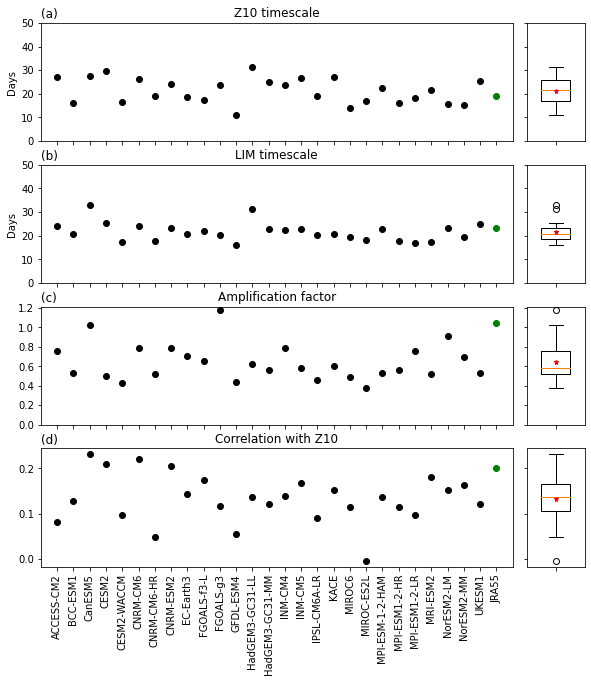

In [37]:
lag_time = hyp_param['lim']['eval_time']

nD = len(D_list)
fig1 = plt.figure(figsize=(10,10))
ax11 = fig1.add_subplot(4, 1, 1)
tau_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    tau_list[i] = D.tau10
    ax11.plot(i+1, tau_list[i],'ko')
ax11.plot(nD+1, D0.tau10,'go')
# ax11.text(0.01,0.02,"{:.2f}".format(np.mean(AMIP_Pac_Cor1)),fontsize=12,transform=ax11.transAxes)
ax11.set_title('Z10 timescale')
ax11.set_ylabel('Days')
ax11.text(0,1.04,'(a)',fontsize=12,transform=ax11.transAxes)
ax11.set_yticks(np.arange(0, 50.1, 10))
ax11.set_xticks(np.arange(1,nD+2))
ax11.set_xticklabels([], rotation='vertical')
ax11.set_xlim(0,nD+2)

fig1.subplots_adjust(right=0.78)
box_ax11 = fig1.add_axes([0.80, ax11.get_position().y0, 0.08, ax11.get_position().y1-ax11.get_position().y0])
box_ax11.boxplot(tau_list, positions=np.array([1]), widths=0.5, showmeans=True, \
                 meanprops=dict(marker='*',markerfacecolor='red',markeredgecolor='red', markersize=5))
box_ax11.set_yticks(np.arange(0, 50.1, 10))
box_ax11.set_xticks([1])
box_ax11.set_yticklabels([])
box_ax11.set_xticklabels([])


ax11 = fig1.add_subplot(4, 1, 2)
tau_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    tau_list[i] = -1/D.model.b[mm].real
    ax11.plot(i+1, tau_list[i],'ko')
ax11.plot(nD+1, -1/D0.model.b[mm].real,'go')
# ax11.text(0.01,0.02,"{:.2f}".format(np.mean(AMIP_Pac_Cor1)),fontsize=12,transform=ax11.transAxes)
ax11.set_title('LIM timescale')
ax11.set_ylabel('Days')
ax11.text(0,1.04,'(b)',fontsize=12,transform=ax11.transAxes)
ax11.set_yticks(np.arange(0, 50.1, 10))
ax11.set_xticks(np.arange(1,nD+2))
ax11.set_xticklabels([], rotation='vertical')
ax11.set_xlim(0,nD+2)

fig1.subplots_adjust(right=0.78)
box_ax11 = fig1.add_axes([0.80, ax11.get_position().y0, 0.08, ax11.get_position().y1-ax11.get_position().y0])
box_ax11.boxplot(tau_list, positions=np.array([1]), widths=0.5, showmeans=True, \
                 meanprops=dict(marker='*',markerfacecolor='red',markeredgecolor='red', markersize=5))
box_ax11.set_yticks(np.arange(0, 50.1, 10))
box_ax11.set_xticks([1])
box_ax11.set_yticklabels([])
box_ax11.set_xticklabels([])


ax11 = fig1.add_subplot(4, 1, 3)
tau_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    tau_list[i] = D.s[lag_time:].mean(axis=0)
    ax11.plot(i+1, tau_list[i],'ko')
ax11.plot(nD+1, D0.s[lag_time:].mean(axis=0),'go')
# ax11.text(0.01,0.02,"{:.2f}".format(np.mean(AMIP_Pac_Cor1)),fontsize=12,transform=ax11.transAxes)
ax11.set_title(f'Amplification factor')
# ax11.set_ylabel('Days')
ax11.text(0,1.04,'(c)',fontsize=12,transform=ax11.transAxes)
ax11.set_yticks(np.arange(0, 1.21, 0.2))
ax11.set_xticks(np.arange(1,nD+2))
ax11.set_xticklabels([], rotation='vertical')
ax11.set_xlim(0,nD+2)

fig1.subplots_adjust(right=0.78)
box_ax11 = fig1.add_axes([0.80, ax11.get_position().y0, 0.08, ax11.get_position().y1-ax11.get_position().y0])
box_ax11.boxplot(tau_list, positions=np.array([1]), widths=0.5, showmeans=True, \
                 meanprops=dict(marker='*',markerfacecolor='red',markeredgecolor='red', markersize=5))
box_ax11.set_yticks(np.arange(0, 1.21, 0.2))
box_ax11.set_xticks([1])
box_ax11.set_yticklabels([])
box_ax11.set_xticklabels([])

p_level = 850
ax11 = fig1.add_subplot(4, 1, 4)
tau_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    k = np.isin(D.level, p_level)
    tau_list[i] = Ct_p[i, lag_time+1:, k].mean(axis=1)
    ax11.plot(i+1, tau_list[i],'ko')
k = np.isin(D0.level, p_level)
ax11.plot(nD+1, Ct_p0[lag_time+1:, k].mean(axis=0),'go')
# ax11.text(0.01,0.02,"{:.2f}".format(np.mean(AMIP_Pac_Cor1)),fontsize=12,transform=ax11.transAxes)
ax11.set_title(f'Correlation with Z10')
# ax11.set_ylabel('Days')
ax11.text(0,1.04,'(d)',fontsize=12,transform=ax11.transAxes)
# ax11.set_yticks(np.arange(0, 1.21, 0.2))
ax11.set_xticks(np.arange(1,nD+2))
ax11.set_xticklabels(model_list+[D0.name], rotation='vertical')
ax11.set_xlim(0,nD+2)

fig1.subplots_adjust(right=0.78)
box_ax11 = fig1.add_axes([0.80, ax11.get_position().y0, 0.08, ax11.get_position().y1-ax11.get_position().y0])
box_ax11.boxplot(tau_list, positions=np.array([1]), widths=0.5, showmeans=True, \
                 meanprops=dict(marker='*',markerfacecolor='red',markeredgecolor='red', markersize=5))
# box_ax11.set_yticks(np.arange(0, 1.21, 0.2))
box_ax11.set_xticks([1])
box_ax11.set_yticklabels([])
box_ax11.set_xticklabels([])


# if True:
#         plt.savefig('Figs2/lim_timescales.png', transparent=True)